In [9]:
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from helpers import load_from_path, save_pdf

In [10]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [11]:
import seaborn as sns

cm = sns.light_palette("purple", as_cmap=True)

exp = "GAS-004"
df = pd.read_excel(f'./final/{exp}/XRD+synthsis_data.xlsx') 

path = Path(f"./final/{exp}/unroll_new/marsdet/0/")

# load the data
res_dict = load_from_path(path)
eval_samples = res_dict["eval_samples"]
eval_samples["id"] = eval_samples.index
# mvar_hv = eval_samples["MVaR_Hypervolume_indicator"]

df = df[
    [
        "Sample ID",
        "id",
        "pH",
        "C_ZnCl",
        "C_NaOH/C_ZnCl",
        "C_NaOH",
        "Q_AC",
        "Q_AIR",
        "N_ZnO",
        # "End",
        "Cond",
        "Aspect Ratio",
        "Peak Ratio",
    ]
]
df.dropna(how="any", axis=1, inplace=True)

# merge eval_samples onto df on id
df = pd.merge(df, eval_samples, on="id")

# only where C_NaOH/C_ZnCl is bigger than 1.6

df.reset_index(drop=True, inplace=True)
df_mean = df.select_dtypes(include=["float64", "int64"]).groupby("id").mean()

df_std = df.select_dtypes(include=["float64", "int64"]).groupby("id").std()

from scipy.stats import norm

def calculate_var(mean, std_dev, alpha=0.9):

    # Calculate the z-score for the given alpha level
    z_score = norm.ppf(alpha)

    # Calculate mVaR for each variable
    var = mean - z_score * std_dev
    return var

df_mean_std = pd.merge(
    df_mean, df_std, left_index=True, right_index=True, suffixes=("_mean", "_std")
)

for col in df_mean.columns:
    df_mean_std[col + "_VaR"] = calculate_var(
        df_mean_std[col + "_mean"], df_mean_std[col + "_std"]
    )

#make separate df for VaR
df_VaR = df_mean_std.filter(like="VaR", axis=1)
# display(df_mean.style.background_gradient(cmap=cm, axis=0).format("{:.2f}"))

# sort columns alphabetically
# df_mean_std = df_mean_std.reindex(sorted(df_mean_std.columns), axis=1)
df_mean_std["id_idx"] = df_mean_std.index
# drop all zerp columns
df_mean_std = df_mean_std.loc[:, (df_mean_std != 0).any(axis=0)]
const_cols = [["C_ZnCl", "C_NaOH/C_ZnCl", "C_NaOH", "Q_AC", "Q_AIR", "N_ZnO"]]

# remove VaR and std for constant columns
for col in const_cols[0]:
    del df_mean_std[col + "_VaR"]
    # del df_mean_std[col + "_std"]
    #rename mean
    df_mean_std.rename(columns={col + "_mean": col}, inplace=True)

df_mean_std["initial_sampling"] = df_mean_std["id_idx"] < 12
df["initial_sampling"] = df["id"] < 12

#reset index
df_mean_std.reset_index(drop=True, inplace=True)

# zero column
df_mean_std["zero"] = 0
 
# display(df_mean_std.style.background_gradient(cmap="Greens", axis=0).format("{:.2f}"))

In [12]:
# df_mean.columns
# ['pH', 'C_ZnCl', 'C_NaOH/C_ZnCl', 'C_NaOH', 'Q_AC', 'Q_AIR', 'N_ZnO',
#        'Cond', 'Aspect Ratio', 'Peak Ratio', 'iterID', 'x1', 'x2', 'x3', 'x4',
#        'f1', 'rho_f1', 'mvar_f1', 'f2', 'rho_f2', 'mvar_f2', 'f3', 'rho_f3',
#        'mvar_f3', 'Expected_f1', 'Uncertainty_f1', 'Acquisition_f1',
#        'Expected_f2', 'Uncertainty_f2', 'Acquisition_f2', 'Expected_f3',
#        'Uncertainty_f3', 'Acquisition_f3', 'Hypervolume_indicator',
#        'MVaR_Hypervolume_indicator']

In [13]:
# add mVaR_Hypervolume_indicator

In [14]:
# %config InlineBackend.figure_format='svg'
# import matplotlib.pyplot as plt
# import matplotlib.patheffects as pe

# # ax.plot(
# #     df_mean_std["Peak Ratio_mean"],
# #     df_mean_std["Aspect Ratio_mean"],
# #     "o",
# #     color=defaultColors[0],
# #     markersize=8, markeredgecolor="black",
# #     label="Mean",
# # )
# # ax.errorbar(
# #     df_mean_std["Peak Ratio_mean"],
# #     df_mean_std["Aspect Ratio_mean"],
# #     xerr=df_mean_std["Peak Ratio_std"],
# #     yerr=df_mean_std["Aspect Ratio_std"],
# #     fmt="o",
# #     color=defaultColors[0],
# #     label="Std",
# #     alpha=0.5,
# # )


# plt.rcParams.update(
#     {
#         "text.usetex": True,
#         "font.family": "serif",
#         "font.serif": ["Helvetica"],
#         # font size
#         "font.size": 16,
#     }
# )
# def is_float_column(column, df):
#     return df[column].dtype in [np.float64, np.float32]

# def get_color(column, df):
#     labels = df[column]
#     if is_float_column(column, df):
#         # Use a continuous colormap for float-valued columns
#         norm = plt.Normalize(labels.min(), labels.max())
#         cmap = plt.cm.viridis
#         colors = cmap(norm(labels))
#         labels = labels.round(2)
#     else:
#         # Use distinct colors for category or integer-valued columns
#         unique_labels = np.unique(labels)
#         cmap = plt.cm.tab10
#         colors_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}
#         colors = np.array([colors_dict[label] for label in labels])
        
#     return colors, labels

# print(df_mean_std.columns)
# colors, labels = get_color("initial_sampling", df_mean_std)

# # Aspect Ratio and Peak Ratio
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# for i, row in df_mean_std.iterrows():
#     color = colors[i]
#     ax.plot(
#         row["Peak Ratio_mean"],
#         row["Aspect Ratio_mean"],
#         "o",
#         color=color,
#         markersize=8,
#         markeredgecolor="black",
#         label="Mean" if i == 0 else None,
#     )
#     ax.errorbar(
#         row["Peak Ratio_mean"],
#         row["Aspect Ratio_mean"],
#         xerr=row["Peak Ratio_std"],
#         yerr=row["Aspect Ratio_std"],
#         fmt="o",
#         color=color,
#         label="Std" if i == 0 else None,
#         alpha=0.5,
#     )
# ax.grid(True)
# ax.set_xlabel("Peak Ratio")
# ax.set_ylabel("Aspect Ratio")
# ax.set_title("Aspect Ratio and Peak Ratio")
# ax.legend()
# plt.show()


# save_pdf(fig, path,"")

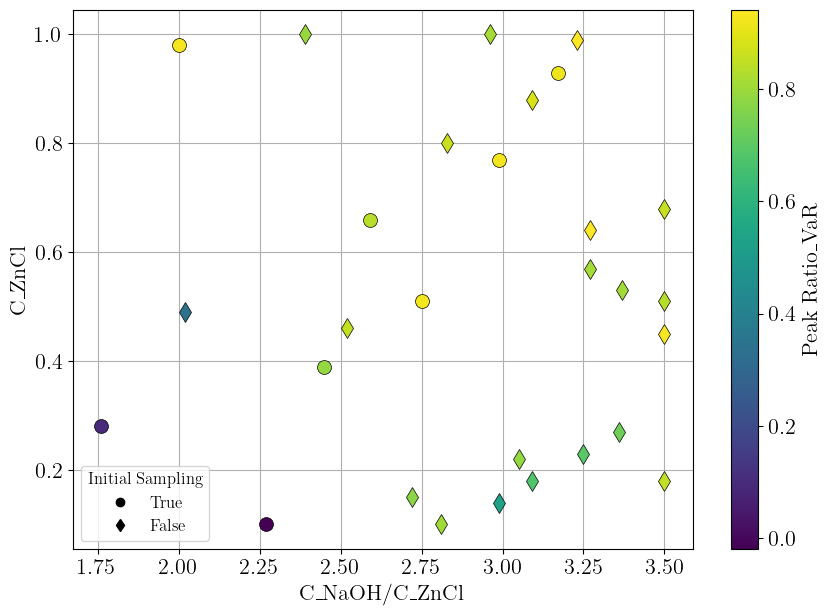

In [15]:

# %config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Helvetica"],
        # font size
        "font.size": 16,
    }
)
def is_float_column(column, df):
    return df[column].dtype in [np.float64, np.float32]

def get_color(column, df):
    labels = df[column]
    if is_float_column(column, df):
        # Use a continuous colormap for float-valued columns
        norm = plt.Normalize(labels.min(), labels.max())
        cmap = plt.cm.viridis
        colors = cmap(norm(labels))
    else:
        # Use distinct colors for category or integer-valued columns
        unique_labels = np.unique(labels)
        cmap = plt.cm.tab10
        colors_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}
        colors = np.array([colors_dict[label] for label in labels])
        
    return colors


def scatter_plot(df, x, y, cc, mc, filter_data=""):

    if filter_data == "filter":
        df = df[df["C_NaOH/C_ZnCl"] > 1.6]
        
    colors = get_color(cc, df)
    colors_dict = {label: colors[i] for i, label in enumerate(df[cc].unique())}

    markers_all = ["o", "d"]
    markers_dict = {label: markers_all[idx % len(markers_all)] for idx, label in enumerate(df[mc].unique())}
    markers = [markers_dict[label] for label in df[mc]]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    for i in range(df.shape[0]):
        row = df.iloc[i]
        color = colors[i]
        marker = markers[i]
        sc=ax.plot(
            row[x],
            row[y],
            marker=marker,
            color=color,
            markersize=10,
            markeredgewidth=0.5,
            markeredgecolor="black",
            alpha=1.,
        )
        
    for m in df[mc].unique():
        ax.plot([], [], marker=markers_dict[m], color="k", label=m, linestyle="None")
        
    # for c in df[cc].unique():
    #     ax.plot([], [], marker="o", color=colors_dict[c], label=f"{cc}: {c}", linestyle="None")

    ax.legend(fontsize=12, title_fontsize=12, title="Initial Sampling")

    # custom colorbar
    if is_float_column(cc, df):
        # Add a colorbar if 'cc' is a float column
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=df[cc].min(), vmax=df[cc].max()))
        sm.set_array([])
        fig.colorbar(sm, ax=ax, label=cc)


    ax.set_xlabel(x)
    ax.set_ylabel(y) 
    ax.grid(True)
    
    return fig, ax

columns = df_mean_std.columns

filter_data = "filter"
# filter_data = ""
x = "C_NaOH/C_ZnCl"
y = "C_ZnCl"
# cc = "zero"
# y = "Aspect Ratio_VaR"
# x = "C_NaOH/C_ZnCl"
cc = "Peak Ratio_VaR"
mc = "initial_sampling"

fig, ax = scatter_plot(df_mean_std, x, y, cc, mc, filter_data)

# fig.show()

path = Path(f"figures/aa/GAS-004/")

save_pdf(fig, path,f"{exp}/agg/{cc}/{mc}", f"{x}+{y}+{cc}+{mc}+{filter_data}".replace("/", "_"))